In [1]:
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from datasets import load_dataset

df = load_dataset("gallifantjack/augtoma_usmle_step_1_original_filtered")
df = df["test"]
df = pd.DataFrame(df)
df.head()

/home/legionjgally/miniconda3/envs/bnb_39_117/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 24/24 [00:00<00:00, 5460.15 examples/s]


,question,options,answer,answer_idx,found_keywords,local_id
0,A 66-year-old man who was recently diagnosed w...,"{'A': 'Aromatic L-amino acid decarboxylase', '...",Monoamine oxidase B,C,"[carbidopa, levodopa]",16
1,A 4-year-old girl with type 1 diabetes mellitu...,{'A': 'Hyperglycemia caused by increased gluco...,Hypoglycemia caused by excess exogenous insulin,D,[insulin],31
2,A 32-year-old woman with hypothyroidism comes ...,"{'A': 'Decreased absorption', 'B': 'Decreased ...",Decreased absorption,A,[thyroxine],34
3,A 48-year-old woman with type 2 diabetes melli...,{'A': 'Create an exercise regimen for the pati...,Explore barriers to diet adherence,B,"[insulin, metformin]",37
4,A 10-year-old boy is brought to the physician ...,"{'A': 'Factor VII (proconvertin)', 'B': 'Fibri...",Glycoprotein IIb-IIIa,C,[thrombin],42


## Replacement counts


In [3]:
dataset_names = [
    # "medmcqa",
    # "bigbio/pubmed_qa",
    "GBaker/MedQA-USMLE-4-options-hf",
    "augtoma/usmle_step_1",
    "augtoma/usmle_step_2",
    "augtoma/usmle_step_3",
    "hails/mmlu_no_train/anatomy",
    "hails/mmlu_no_train/clinical_knowledge",
    "hails/mmlu_no_train/college_medicine",
    "hails/mmlu_no_train/medical_genetics",
    "hails/mmlu_no_train/professional_medicine",
    "hails/mmlu_no_train/college_biology",
]

replacement_directions = ["brand_to_generic", "generic_to_brand", "none"]

In [4]:
def load_replacement_counts(dataset, direction):
    """
    Load the replacement counts from a JSON file.

    Args:
    dataset (str): The dataset name.
    direction (str): The direction of replacements (e.g., brand_to_generic, generic_to_brand).

    Returns:
    pd.DataFrame: A DataFrame containing the replacement counts.
    """
    # convert / to _ for file path
    dataset_name = dataset.replace("/", "_")
    for split in ["train", "val", "dev", "test"]:
        counts_file_path = (
            f"../counts/{dataset_name}/{split}/{split}_{direction}.parquet"
        )

    if os.path.exists(counts_file_path):
        drug_replacement_counts = pd.read_parquet(counts_file_path)

        drug_replacement_counts["dataset"] = dataset
        drug_replacement_counts["direction"] = direction
        drug_replacement_counts["split"] = split

        return drug_replacement_counts
    else:
        print(f"File not found: {counts_file_path}")
        return pd.DataFrame()


test = load_replacement_counts("GBaker/MedQA-USMLE-4-options-hf", "brand_to_generic")
test.head()

File not found: ../counts/GBaker_MedQA-USMLE-4-options-hf/test/test_brand_to_generic.parquet


""


#### Get highest counts per dataset


In [5]:
replacements_df = pd.DataFrame()

# Load replacement counts for each dataset and direction
for dataset in dataset_names:
    for direction in replacement_directions:
        df_replacements = load_replacement_counts(dataset, direction)
        if not df_replacements.empty:
            replacements_df = pd.concat(
                [replacements_df, df_replacements], ignore_index=True
            )

# Ensure count is integer
replacements_df["count"] = replacements_df["count"].astype(int)

# print the highest 50 counts for each dataset and direction
print("\nHighest Replacement Counts:")
for dataset in dataset_names:
    for direction in replacement_directions:
        df = replacements_df[
            (replacements_df["dataset"] == dataset)
            & (replacements_df["direction"] == direction)
        ]
        if not df.empty:
            df = df.sort_values("count", ascending=False)
            print(f"\n{dataset} - {direction}")
            print(df.head(50))

File not found: ../counts/GBaker_MedQA-USMLE-4-options-hf/test/test_brand_to_generic.parquet
File not found: ../counts/GBaker_MedQA-USMLE-4-options-hf/test/test_generic_to_brand.parquet
File not found: ../counts/GBaker_MedQA-USMLE-4-options-hf/test/test_none.parquet
File not found: ../counts/augtoma_usmle_step_1/test/test_brand_to_generic.parquet
File not found: ../counts/augtoma_usmle_step_1/test/test_generic_to_brand.parquet
File not found: ../counts/augtoma_usmle_step_1/test/test_none.parquet
File not found: ../counts/augtoma_usmle_step_2/test/test_brand_to_generic.parquet
File not found: ../counts/augtoma_usmle_step_2/test/test_generic_to_brand.parquet
File not found: ../counts/augtoma_usmle_step_2/test/test_none.parquet
File not found: ../counts/augtoma_usmle_step_3/test/test_brand_to_generic.parquet
File not found: ../counts/augtoma_usmle_step_3/test/test_generic_to_brand.parquet
File not found: ../counts/augtoma_usmle_step_3/test/test_none.parquet
File not found: ../counts/hails

KeyError: 'count'

### Remove any overlapping keywords


In [ ]:
overlapping_keywords = [
    "today",
    "thrive",
    "program",
    "react",
    "perform",
    "tomorrow"
    # GBaker/MedQA-USMLE-4-options-hf - brand_to_generic
    "bronchial",
    "copd",
    "duration",
    "matrix",
    "blockade",
    "sustain",
    "overtime",
    "android",
    "suppressor",
    "nephron",
    # GBaker/MedQA-USMLE-4-options-hf - generic_to_brand
    "alcohol",
    "liver",
    "thyroid",
    "potassium",
    "prothrombin",
    "alanine",
    "water",
    # augtoma/usmle_step_1 - brand_to_generic
    # augtoma/usmle_step_1 - generic_to_brand
    "oxygen",
    "liver",
    "alcohol",
    "water",
    "thryroid",
    "peanut",
    # augtoma/usmle_step_2 - brand_to_generic
    # augtoma/usmle_step_2 - generic_to_brand
    "alcohol",
    "urea",
    "nitrogen",
    "thryroid",
    "liver",
    # augtoma/usmle_step_3 - brand_to_generic
    # hails/mmlu_no_train/anatomy - brand_to_generic
    "matrix",
    # hails/mmlu_no_train/anatomy - generic_to_brand
    "liver",
    "thryroid",
    "nitrogen",
    "acetylcholine",
    # hails/mmlu_no_train/clinical_knowledge - brand_to_generic
    "duration",
    "sustain",
    "copd",
    # hails/mmlu_no_train/clinical_knowledge - generic_to_brand
    "lactate",
    "water",
    "liver",
    "alcohol",
    "urea",
    "thyroid",
    # hails/mmlu_no_train/college_medicine - brand_to_generic
    "sustain",
    "nephron",
    "rid",
    "excel",
    # hails/mmlu_no_train/college_medicine - generic_to_brand
    "oxygen",
    "glucose",
    "water",
    "lactate",
    "urea",
    "potassium",
    "alcohol",
    "arginine",
    "glutamine",
    "testosterone",
    "tyrosine",
    "ethanol",
    "progesterone",
    "isoleucine",
    "liver",
    "choline",
    "glycine",
    "glutamate",
    "nitrogen",
    "amylase",
    "alanine",
    "acetylcholine",
    "leucine",
    # hails/mmlu_no_train/medical_genetics - brand_to_generic
    "suppressor",
    # hails/mmlu_no_train/medical_genetics - generic_to_brand
    "phenylalanine",
    "liver",
    # hails/mmlu_no_train/professional_medicine - brand_to_generic
    # hails/mmlu_no_train/professional_medicine - generic_to_brand
    "oxygen",
    "thryoid",
    "liver",
    "alcohol",
    "water",
    "amylase",
    "potassium",
    # hails/mmlu_no_train/college_biology - brand_to_generic
    "matrix",
    "keystone",
    "symmetry",
    # hails/mmlu_no_train/college_biology - generic_to_brand
    "water",
    "nitrogen",
    "starch",
    "sulfur",
    "glucose",
    "alcohol",
    "phosphorus",
    "tyrosine",
    "cysteine",
    "acetylcholine",
    "sucrose",
    "ethanol",
    "urea",
    "oxygen",
]

### Save new drug list without overlapping terms


In [ ]:
# Filter out the overlapping_keywords from filtered_replacements_df counts
filtered_replacements_df = replacements_df[
    ~replacements_df["keyword"].isin(overlapping_keywords)
]
# print the highest 50 counts for each dataset and direction
print("\nHighest Replacement Counts:")
for dataset in dataset_names:
    for direction in replacement_directions:
        df = filtered_replacements_df[
            (filtered_replacements_df["dataset"] == dataset)
            & (filtered_replacements_df["direction"] == direction)
        ]
        if not df.empty:
            df = df.sort_values("count", ascending=False)
            print(f"\n{dataset} - {direction}")
            print(df.head(50))


Highest Replacement Counts:

GBaker/MedQA-USMLE-4-options-hf - brand_to_generic
          keyword  count                          dataset         direction  \
5582       schiff      2  GBaker/MedQA-USMLE-4-options-hf  brand_to_generic   
6937      welchol      1  GBaker/MedQA-USMLE-4-options-hf  brand_to_generic   
2190       epipen      1  GBaker/MedQA-USMLE-4-options-hf  brand_to_generic   
413      antabuse      1  GBaker/MedQA-USMLE-4-options-hf  brand_to_generic   
0        a-cillin      0  GBaker/MedQA-USMLE-4-options-hf  brand_to_generic   
4837     photocil      0  GBaker/MedQA-USMLE-4-options-hf  brand_to_generic   
4835     phos-aid      0  GBaker/MedQA-USMLE-4-options-hf  brand_to_generic   
4834     phisohex      0  GBaker/MedQA-USMLE-4-options-hf  brand_to_generic   
4833     phimetin      0  GBaker/MedQA-USMLE-4-options-hf  brand_to_generic   
4832       phicon      0  GBaker/MedQA-USMLE-4-options-hf  brand_to_generic   
4831       phexxi      0  GBaker/MedQA-USMLE-4-opt

### Save final counts


In [ ]:
# Group by Dataset and Direction, and sum the counts of replacements
replacements_sum = (
    filtered_replacements_df.groupby(["dataset", "direction"])["count"]
    .sum()
    .reset_index()
)

# Save the summed replacements to a CSV file
output_file_path = "../counts/summed_replacements_counts.csv"
replacements_sum.to_csv(output_file_path, index=False)

print("\nSummed Replacements Counts:")
print(replacements_sum)


Summed Replacements Counts:
                                      dataset         direction  count
0             GBaker/MedQA-USMLE-4-options-hf  brand_to_generic      5
1             GBaker/MedQA-USMLE-4-options-hf  generic_to_brand   1638
2                        augtoma/usmle_step_1  brand_to_generic      0
3                        augtoma/usmle_step_1  generic_to_brand     49
4                        augtoma/usmle_step_2  brand_to_generic      0
5                        augtoma/usmle_step_2  generic_to_brand    108
6                        augtoma/usmle_step_3  brand_to_generic      1
7                        augtoma/usmle_step_3  generic_to_brand    132
8                 hails/mmlu_no_train/anatomy  brand_to_generic      1
9                 hails/mmlu_no_train/anatomy  generic_to_brand      4
10     hails/mmlu_no_train/clinical_knowledge  brand_to_generic      1
11     hails/mmlu_no_train/clinical_knowledge  generic_to_brand     20
12        hails/mmlu_no_train/college_biology  b

## Visualise number replacements


/var/folders/06/cy8f7k7d5pb31b4b4fpr97z80000gn/T/ipykernel_6967/973394750.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/06/cy8f7k7d5pb31b4b4fpr97z80000gn/T/ipykernel_6967/973394750.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


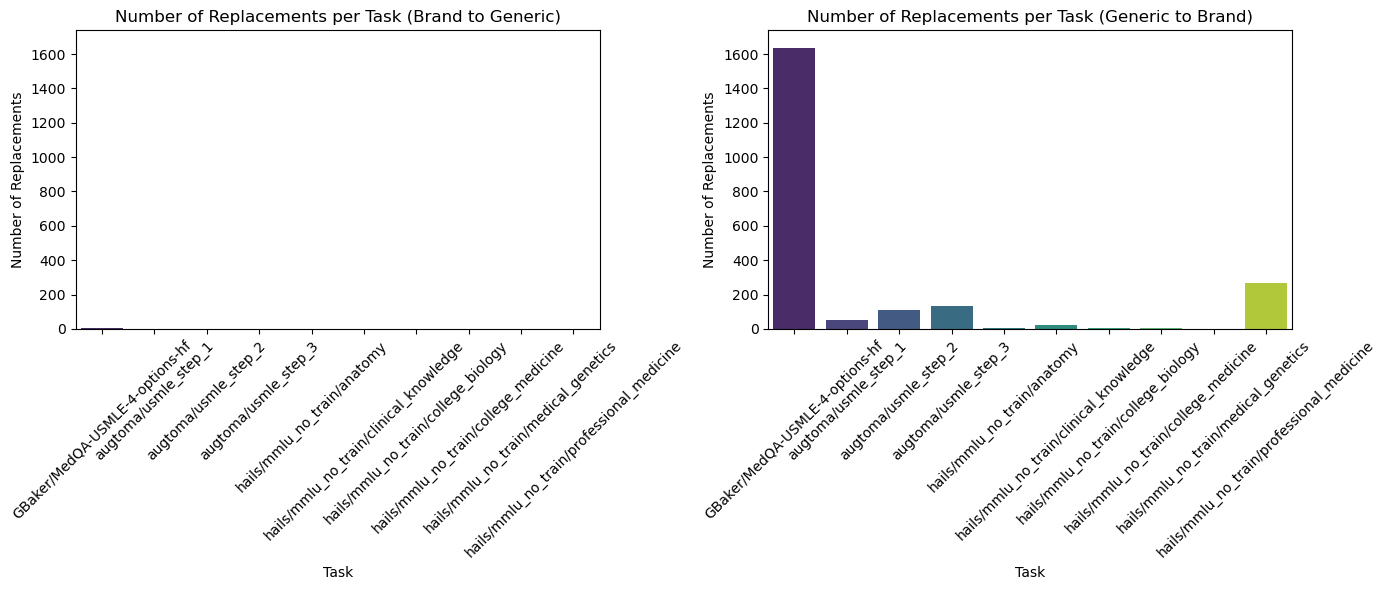

In [ ]:
def plot_replacement_histograms(replacements_sum):
    """
    Plot histograms of the number of replacements per task for both directions.

    Args:
    replacements_sum (pd.DataFrame): A DataFrame containing the replacement counts.
    """
    # Create separate histograms for each direction
    plt.figure(figsize=(14, 6))

    # Determine shared y-axis limit
    max_count = 100 + replacements_sum["count"].max()

    # Histogram for brand_to_generic
    plt.subplot(1, 2, 1)
    sns.barplot(
        data=replacements_sum[replacements_sum["direction"] == "brand_to_generic"],
        x="dataset",
        y="count",
        palette="viridis",
    )
    plt.xticks(rotation=45)
    plt.title("Number of Replacements per Task (Brand to Generic)")
    plt.xlabel("Task")
    plt.ylabel("Number of Replacements")
    plt.ylim(0, max_count)

    # Histogram for generic_to_brand
    plt.subplot(1, 2, 2)
    sns.barplot(
        data=replacements_sum[replacements_sum["direction"] == "generic_to_brand"],
        x="dataset",
        y="count",
        palette="viridis",
    )
    plt.xticks(rotation=45)
    plt.title("Number of Replacements per Task (Generic to Brand)")
    plt.xlabel("Task")
    plt.ylabel("Number of Replacements")
    plt.ylim(0, max_count)

    plt.tight_layout()
    plt.show()


plot_replacement_histograms(replacements_sum)

## Final brand and generic replacements csv to be used for replacement


In [ ]:
brand_generic_old = pd.read_csv("../RxNorm_eval/brand_to_generic.csv")
generic_brand_old = pd.read_csv("../RxNorm_eval/generic_to_brand.csv")

print(f"Length of brand_generic_old: {len(brand_generic_old)}")
print(f"Length of generic_brand_old: {len(generic_brand_old)}")

Length of brand_generic_old: 11039
Length of generic_brand_old: 2316


In [ ]:
# go through brand_generic_old and generic_brand_old and remove the rows that contain the keywords in overlapping_keywords
brand_generic = brand_generic_old[
    ~brand_generic_old["brand"].isin(overlapping_keywords)
    & ~brand_generic_old["generic"].isin(overlapping_keywords)
]

generic_brand = generic_brand_old[
    ~generic_brand_old["brand"].isin(overlapping_keywords)
    & ~generic_brand_old["generic"].isin(overlapping_keywords)
]

print(f"Length of brand_generic: {len(brand_generic)}")
print(f"Length of generic_brand: {len(generic_brand)}")

# Assert does not contain overlapping keywords
assert not brand_generic["brand"].isin(overlapping_keywords).any()
assert not generic_brand["brand"].isin(overlapping_keywords).any()
assert not brand_generic["generic"].isin(overlapping_keywords).any()
assert not generic_brand["generic"].isin(overlapping_keywords).any()

Length of brand_generic: 10716
Length of generic_brand: 2281


In [ ]:
# Save final brand_to_generic and generic_to_brand to CSV files
brand_generic.to_csv("../RxNorm_eval/filterered_brand_to_generic.csv", index=False)
generic_brand.to_csv("../RxNorm_eval/filterered_generic_to_brand.csv", index=False)